# Demontration of neural network MCMC sampler trained with maximum Entropy objective 


## Please run Cells in the order provided.

Requirements: pytorch 1.6.0 (cuda not required), numpy, matplotlib

### First we import modules and setup the model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from L2RW_models import L2GradRW, CovMALA
from L2RW import L2GradRW_M, adjust_lr
from distributions import distributions
from scipy.stats import entropy
from statsmodels.tsa.stattools import acf as autocorr
from tqdm import tqdm
from scipy.stats import multivariate_normal

In [2]:
def neff(arr):
    n = len(arr)
    acf = autocorr(arr, nlags=n, fft=True)
    sums = 0
    for k in range(1, len(acf)):
        sums = sums + (n-k)*acf[k]/n

    return n/(1+2*sums)

# Gravitational Wave Likelihood Model

In [3]:
# Define the waveform function h.
def h(t, phase, freq, dfreq, ddfreq):
    return torch.sin(phase + freq * t + dfreq * t**2 + ddfreq * t**3)

# Define the log likelihood function.
def log_likelihood(template, observed):
    # Calculate the difference and norm squared (waveform inner product)
    difference = observed - template
    norm_squared = np.linalg.norm(difference, axis=-1)**2
    return -0.5 * norm_squared  # log likelihood is -0.5 * ||difference||^2

# Define the time vector for the waveform.
t = torch.arange(0, 100, 0.1)  # From 0 to 100 in steps of 0.1

# Define a grid for phase and frequency.
phase_t = torch.arange(-torch.pi, torch.pi, 2 * torch.pi / 100)
freq_t  = torch.arange(0.8, 1.8, 1.0 / 100)

# Fixed parameters for generating the template waveform.
phase = 0
freq  = 1
dfreq = 0.1
ddfreq = 0.001

# Generate the template waveform (a 1D tensor over t).
template = torch.tensor([h(ti, phase, freq, dfreq, ddfreq) for ti in t])

# Generate the observed waveforms over the grid:
# For each frequency in freq_t and each phase in phase_t, compute a waveform over t.
observed = torch.tensor(np.array([[h(t, phasei, freqi, dfreq, ddfreq) for phasei in phase_t] for freqi in freq_t]))

# Compute the log likelihood for each grid point.
# loglike will have shape (len(freq_t), len(phase_t))
loglike = log_likelihood(template, observed)

# Optional: shift values so the minimum is zero (makes contour levels easier to display)
loglike = loglike - loglike.min()

# Prepare grid for plotting.
phase_t_np = phase_t.numpy()
freq_t_np  = freq_t.numpy()
X, Y = np.meshgrid(phase_t_np, freq_t_np)

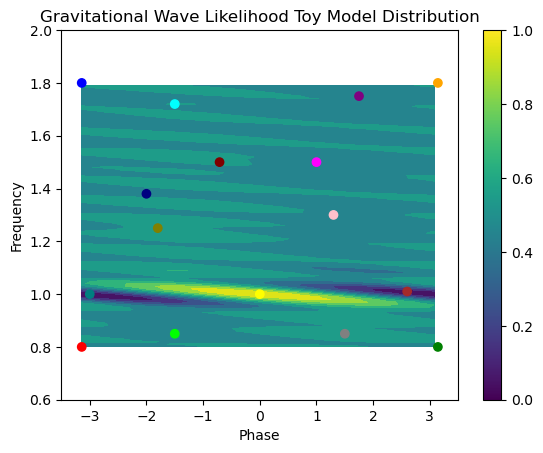

In [6]:
x0 = torch.tensor([-np.pi,-np.pi,np.pi,np.pi,1.75,-1.5,1,0,-1.5,-3,2.6,-2, 1.3,-1.8,-0.71,1.5])
y0 = torch.tensor([0.8,1.8,0.8,1.8,1.75,1.72,1.5,1,0.85,1,1.01,1.38,1.3,1.25,1.5,0.85])
colors = np.array(['red','blue','green','orange','purple','cyan','magenta','yellow','lime','teal','brown','navy','pink','olive','maroon','gray'])

plt.contourf(X,Y,loglike,9)
plt.scatter(x0,y0,c=colors)
plt.colorbar();
plt.xlabel('Phase')
plt.ylabel('Frequency')
plt.title('Gravitational Wave Likelihood Toy Model Distribution')
plt.xlim([-3.5, 3.5])
plt.ylim([0.6, 2])
plt.show()

In [40]:
data_dim = 2
dim = 32
N_steps = 2
dist = distributions('toy',d=data_dim)
RW = L2GradRW(dist.Ex,data_dim,dim,N_steps,epsi=0.02,net_type='MLP',grad_mode='R',bias=True,act='elu') #diag_gaussian example use 0.001 epsi init
RW_controller = L2GradRW_M(RW,beta=1e-2,beta_max=1e3,rho_beta=0.1,adapt_beta=True,a_target=0.9,
                 lr=1e-3,momo=0.9,rms_momo=0.95,grad_norm=10,N_steps=10000)

### Train the Sampler

sldjxx is the proposal entropy (up to a constant equal to the entropy of Gaussian), it should increase during training

In [41]:
#train with real samples
bs = 512
for i in tqdm(range(5000)):
    x_init = dist.sample(bs)
    x, accept_rate, sldjxx, L2jump = RW_controller.sample_train(x_init,T=1,print_log= (True if i%100==0 else False))
    #adjust_lr(RW_controller,i,warmup=False,min_lr=1e-2)
    if i>5 and i%1000 == 0:
        print('1ksteps done, now {}'.format(i))

  0%|                                                                                 | 2/5000 [00:00<13:13,  6.30it/s]

jump 2.265e-02, Exp jump1.186e-03, accept 0.086,log_a -6.148e+03, sldjxx -7.824,beta 1.000e-02, epsi 1.998e-02


  2%|█▌                                                                             | 102/5000 [00:16<12:38,  6.46it/s]

jump 1.450e-02, Exp jump7.034e-03, accept 0.313,log_a -8.821e+01, sldjxx -6.776,beta 1.000e-02, epsi 1.956e-02


  4%|███▏                                                                           | 202/5000 [00:31<12:23,  6.45it/s]

jump 1.065e-02, Exp jump4.583e-03, accept 0.392,log_a -2.490e+01, sldjxx -6.653,beta 1.000e-02, epsi 1.926e-02


  6%|████▊                                                                          | 302/5000 [00:47<12:07,  6.46it/s]

jump 1.654e-02, Exp jump7.690e-03, accept 0.403,log_a -2.002e+01, sldjxx -6.326,beta 1.000e-02, epsi 1.926e-02


  8%|██████▎                                                                        | 402/5000 [01:02<11:56,  6.42it/s]

jump 1.402e-02, Exp jump6.473e-03, accept 0.453,log_a -7.878e+00, sldjxx -6.218,beta 1.000e-02, epsi 1.929e-02


 10%|███████▉                                                                       | 502/5000 [01:18<11:56,  6.28it/s]

jump 1.784e-02, Exp jump7.638e-03, accept 0.398,log_a -1.899e+01, sldjxx -5.892,beta 1.000e-02, epsi 1.946e-02


 12%|█████████▌                                                                     | 602/5000 [01:34<11:39,  6.29it/s]

jump 2.174e-02, Exp jump1.062e-02, accept 0.408,log_a -9.998e+00, sldjxx -5.653,beta 1.000e-02, epsi 1.927e-02


 14%|███████████                                                                    | 702/5000 [01:51<11:49,  6.05it/s]

jump 2.114e-02, Exp jump8.595e-03, accept 0.398,log_a -1.453e+01, sldjxx -5.228,beta 1.000e-02, epsi 1.920e-02


 16%|████████████▋                                                                  | 802/5000 [02:08<11:21,  6.16it/s]

jump 2.392e-02, Exp jump1.231e-02, accept 0.485,log_a -3.773e+00, sldjxx -5.162,beta 1.000e-02, epsi 1.907e-02


 18%|██████████████▎                                                                | 902/5000 [02:25<12:54,  5.29it/s]

jump 2.420e-02, Exp jump1.127e-02, accept 0.445,log_a -6.813e+00, sldjxx -5.225,beta 1.000e-02, epsi 1.904e-02


 20%|███████████████▋                                                              | 1002/5000 [02:42<10:57,  6.08it/s]

jump 2.829e-02, Exp jump1.274e-02, accept 0.449,log_a -2.171e+00, sldjxx -5.277,beta 1.000e-02, epsi 1.900e-02
1ksteps done, now 1000


 22%|█████████████████▏                                                            | 1102/5000 [02:59<10:43,  6.06it/s]

jump 2.183e-02, Exp jump1.047e-02, accept 0.483,log_a -9.419e+00, sldjxx -5.462,beta 1.000e-02, epsi 1.893e-02


 24%|██████████████████▊                                                           | 1202/5000 [03:16<10:33,  6.00it/s]

jump 1.908e-02, Exp jump8.920e-03, accept 0.449,log_a -1.854e+00, sldjxx -6.026,beta 1.000e-02, epsi 1.870e-02


 26%|████████████████████▎                                                         | 1301/5000 [03:32<10:32,  5.85it/s]

jump 1.800e-02, Exp jump7.860e-03, accept 0.446,log_a -1.138e+01, sldjxx -5.677,beta 1.000e-02, epsi 1.879e-02


 28%|█████████████████████▊                                                        | 1402/5000 [03:49<09:40,  6.20it/s]

jump 2.018e-02, Exp jump1.016e-02, accept 0.457,log_a -6.953e+00, sldjxx -5.471,beta 1.000e-02, epsi 1.875e-02


 30%|███████████████████████▍                                                      | 1502/5000 [04:06<10:02,  5.80it/s]

jump 2.145e-02, Exp jump9.328e-03, accept 0.442,log_a -1.811e+01, sldjxx -4.948,beta 1.000e-02, epsi 1.873e-02


 32%|████████████████████████▉                                                     | 1602/5000 [04:23<09:32,  5.93it/s]

jump 1.925e-02, Exp jump6.989e-03, accept 0.435,log_a -1.111e+01, sldjxx -5.204,beta 1.000e-02, epsi 1.868e-02


 34%|██████████████████████████▌                                                   | 1702/5000 [04:39<08:59,  6.12it/s]

jump 1.742e-02, Exp jump7.392e-03, accept 0.457,log_a -4.292e+00, sldjxx -5.406,beta 1.000e-02, epsi 1.856e-02


 36%|████████████████████████████                                                  | 1802/5000 [04:55<08:33,  6.22it/s]

jump 1.658e-02, Exp jump8.949e-03, accept 0.477,log_a -1.105e+00, sldjxx -5.408,beta 1.000e-02, epsi 1.856e-02


 38%|█████████████████████████████▋                                                | 1902/5000 [05:11<08:15,  6.25it/s]

jump 1.278e-02, Exp jump6.725e-03, accept 0.511,log_a 6.956e+00, sldjxx -5.755,beta 1.000e-02, epsi 1.840e-02


 40%|███████████████████████████████▏                                              | 2002/5000 [05:27<07:58,  6.27it/s]

jump 1.241e-02, Exp jump6.644e-03, accept 0.495,log_a 2.703e+00, sldjxx -5.646,beta 1.000e-02, epsi 1.843e-02
1ksteps done, now 2000


 42%|████████████████████████████████▊                                             | 2102/5000 [05:43<07:39,  6.31it/s]

jump 1.147e-02, Exp jump6.544e-03, accept 0.480,log_a -5.353e-01, sldjxx -5.899,beta 1.000e-02, epsi 1.832e-02


 44%|██████████████████████████████████▎                                           | 2202/5000 [05:59<07:17,  6.39it/s]

jump 1.076e-02, Exp jump5.355e-03, accept 0.517,log_a -1.287e+00, sldjxx -5.931,beta 1.000e-02, epsi 1.822e-02


 46%|███████████████████████████████████▉                                          | 2302/5000 [06:15<07:01,  6.40it/s]

jump 1.193e-02, Exp jump7.728e-03, accept 0.533,log_a 3.071e+00, sldjxx -5.636,beta 1.000e-02, epsi 1.824e-02


 48%|█████████████████████████████████████▍                                        | 2402/5000 [06:30<06:48,  6.37it/s]

jump 1.148e-02, Exp jump5.135e-03, accept 0.507,log_a -6.199e+00, sldjxx -5.633,beta 1.000e-02, epsi 1.833e-02


 50%|███████████████████████████████████████                                       | 2502/5000 [06:46<06:30,  6.40it/s]

jump 1.186e-02, Exp jump6.220e-03, accept 0.512,log_a -1.996e+00, sldjxx -5.709,beta 1.000e-02, epsi 1.835e-02


 52%|████████████████████████████████████████▌                                     | 2602/5000 [07:01<06:07,  6.52it/s]

jump 1.207e-02, Exp jump5.773e-03, accept 0.526,log_a -1.274e+00, sldjxx -5.691,beta 1.000e-02, epsi 1.833e-02


 54%|██████████████████████████████████████████▏                                   | 2702/5000 [07:17<05:59,  6.39it/s]

jump 1.448e-02, Exp jump7.007e-03, accept 0.534,log_a -5.001e+00, sldjxx -5.426,beta 1.000e-02, epsi 1.832e-02


 56%|███████████████████████████████████████████▋                                  | 2802/5000 [07:32<05:40,  6.46it/s]

jump 1.216e-02, Exp jump6.704e-03, accept 0.532,log_a 8.772e-02, sldjxx -5.730,beta 1.000e-02, epsi 1.832e-02


 58%|█████████████████████████████████████████████▎                                | 2902/5000 [07:48<05:23,  6.49it/s]

jump 1.181e-02, Exp jump5.701e-03, accept 0.469,log_a -4.579e+00, sldjxx -5.715,beta 1.000e-02, epsi 1.836e-02


 60%|██████████████████████████████████████████████▊                               | 3002/5000 [08:03<05:03,  6.58it/s]

jump 6.095e-03, Exp jump2.424e-03, accept 0.467,log_a -5.423e+00, sldjxx -5.832,beta 1.000e-02, epsi 1.829e-02
1ksteps done, now 3000


 62%|████████████████████████████████████████████████▍                             | 3102/5000 [08:18<04:46,  6.62it/s]

jump 6.238e-03, Exp jump3.092e-03, accept 0.521,log_a 9.176e-01, sldjxx -6.030,beta 1.000e-02, epsi 1.827e-02


 64%|█████████████████████████████████████████████████▉                            | 3202/5000 [08:34<04:42,  6.36it/s]

jump 5.992e-03, Exp jump2.320e-03, accept 0.516,log_a 2.505e+00, sldjxx -6.113,beta 1.000e-02, epsi 1.825e-02


 66%|███████████████████████████████████████████████████▌                          | 3302/5000 [08:49<04:14,  6.66it/s]

jump 5.018e-03, Exp jump2.213e-03, accept 0.493,log_a 5.923e+00, sldjxx -6.224,beta 1.000e-02, epsi 1.825e-02


 68%|█████████████████████████████████████████████████████                         | 3402/5000 [09:04<04:03,  6.57it/s]

jump 4.116e-03, Exp jump1.700e-03, accept 0.495,log_a 4.543e-01, sldjxx -6.354,beta 1.000e-02, epsi 1.823e-02


 70%|██████████████████████████████████████████████████████▋                       | 3502/5000 [09:19<03:43,  6.69it/s]

jump 4.121e-03, Exp jump1.996e-03, accept 0.479,log_a -2.160e+00, sldjxx -6.314,beta 1.000e-02, epsi 1.822e-02


 72%|████████████████████████████████████████████████████████▏                     | 3602/5000 [09:34<03:32,  6.58it/s]

jump 5.042e-03, Exp jump2.055e-03, accept 0.498,log_a -1.182e+00, sldjxx -6.376,beta 1.000e-02, epsi 1.825e-02


 74%|█████████████████████████████████████████████████████████▊                    | 3702/5000 [09:49<03:14,  6.66it/s]

jump 4.600e-03, Exp jump1.768e-03, accept 0.524,log_a -3.360e+00, sldjxx -6.300,beta 1.000e-02, epsi 1.825e-02


 76%|███████████████████████████████████████████████████████████▎                  | 3802/5000 [10:04<03:01,  6.61it/s]

jump 4.322e-03, Exp jump1.867e-03, accept 0.480,log_a 5.269e+00, sldjxx -6.353,beta 1.000e-02, epsi 1.824e-02


 78%|████████████████████████████████████████████████████████████▊                 | 3902/5000 [10:20<02:44,  6.67it/s]

jump 3.841e-03, Exp jump1.471e-03, accept 0.500,log_a 2.453e-01, sldjxx -6.348,beta 1.000e-02, epsi 1.826e-02


 80%|██████████████████████████████████████████████████████████████▍               | 4002/5000 [10:34<02:28,  6.71it/s]

jump 4.416e-03, Exp jump2.155e-03, accept 0.490,log_a -3.508e+00, sldjxx -6.219,beta 1.000e-02, epsi 1.825e-02
1ksteps done, now 4000


 82%|███████████████████████████████████████████████████████████████▉              | 4102/5000 [10:49<02:14,  6.69it/s]

jump 4.656e-03, Exp jump2.024e-03, accept 0.483,log_a 7.207e-01, sldjxx -6.336,beta 1.000e-02, epsi 1.828e-02


 84%|█████████████████████████████████████████████████████████████████▌            | 4202/5000 [11:04<01:59,  6.70it/s]

jump 4.539e-03, Exp jump2.585e-03, accept 0.482,log_a 5.827e-01, sldjxx -6.256,beta 1.000e-02, epsi 1.827e-02


 86%|███████████████████████████████████████████████████████████████████           | 4302/5000 [11:19<01:46,  6.56it/s]

jump 4.183e-03, Exp jump1.531e-03, accept 0.481,log_a -1.028e+01, sldjxx -6.171,beta 1.000e-02, epsi 1.827e-02


 88%|████████████████████████████████████████████████████████████████████▋         | 4402/5000 [11:34<01:29,  6.67it/s]

jump 4.397e-03, Exp jump2.150e-03, accept 0.479,log_a -1.138e+00, sldjxx -6.096,beta 1.000e-02, epsi 1.825e-02


 90%|██████████████████████████████████████████████████████████████████████▏       | 4502/5000 [11:49<01:14,  6.67it/s]

jump 3.570e-03, Exp jump1.681e-03, accept 0.529,log_a 1.864e+00, sldjxx -6.178,beta 1.000e-02, epsi 1.824e-02


 92%|███████████████████████████████████████████████████████████████████████▊      | 4602/5000 [12:04<00:59,  6.71it/s]

jump 4.102e-03, Exp jump2.004e-03, accept 0.557,log_a -9.470e-01, sldjxx -6.231,beta 1.000e-02, epsi 1.823e-02


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4702/5000 [12:19<00:45,  6.61it/s]

jump 4.237e-03, Exp jump1.778e-03, accept 0.506,log_a -6.432e+00, sldjxx -6.155,beta 1.000e-02, epsi 1.823e-02


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4802/5000 [12:34<00:29,  6.67it/s]

jump 4.336e-03, Exp jump1.811e-03, accept 0.496,log_a -1.433e+00, sldjxx -6.161,beta 1.000e-02, epsi 1.820e-02


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4902/5000 [12:49<00:14,  6.67it/s]

jump 4.792e-03, Exp jump2.334e-03, accept 0.487,log_a -7.373e+00, sldjxx -6.189,beta 1.000e-02, epsi 1.824e-02


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [13:04<00:00,  6.37it/s]


### Sample continuously for 10000 steps

In [42]:
x = torch.tensor(np.array([x0,y0])).T
x_list = []
x_list.append(x)
for i in tqdm(range(10000)):
    x,xp,accept_vect,_ = RW_controller.sample(x,1,grad=False,print_log= True if i%1000==0 else False,)
    x_list.append(x.clone())

  0%|                                                                               | 12/10000 [00:00<02:54, 57.13it/s]

accept 0.4375


 10%|███████▊                                                                     | 1011/10000 [00:16<02:19, 64.54it/s]

accept 0.0625


 20%|███████████████▍                                                             | 2012/10000 [00:31<02:05, 63.85it/s]

accept 0.0


 30%|███████████████████████▏                                                     | 3006/10000 [00:46<01:47, 64.78it/s]

accept 0.0


 40%|██████████████████████████████▊                                              | 4007/10000 [01:02<01:33, 64.05it/s]

accept 0.0


 50%|██████████████████████████████████████▌                                      | 5008/10000 [01:17<01:16, 65.01it/s]

accept 0.0


 60%|██████████████████████████████████████████████▎                              | 6009/10000 [01:33<01:01, 64.89it/s]

accept 0.0


 70%|█████████████████████████████████████████████████████▉                       | 7010/10000 [01:48<00:45, 65.04it/s]

accept 0.0625


 80%|█████████████████████████████████████████████████████████████▋               | 8011/10000 [02:04<00:30, 64.74it/s]

accept 0.125


 90%|█████████████████████████████████████████████████████████████████████▍       | 9012/10000 [02:19<00:15, 64.94it/s]

accept 0.0


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:34<00:00, 64.63it/s]


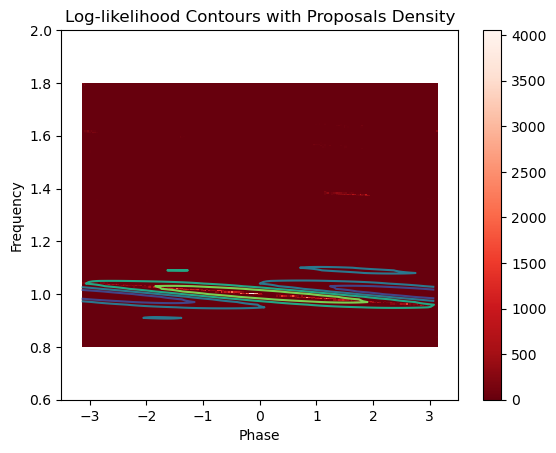

In [43]:
x_try = np.array(x_list)
plt.contour(X, Y, loglike, levels=5, cmap='viridis')
plt.hist2d(x_try[:,:,0].flatten(),x_try[:,:,1].flatten(), bins=(200,200), cmap=plt.cm.Reds_r)
plt.xlabel('Phase')
plt.ylabel('Frequency')
plt.title('Log-likelihood Contours with Proposals Density')
plt.colorbar()
plt.xlim([-3.5, 3.5])
plt.ylim([0.6, 2])
plt.show()

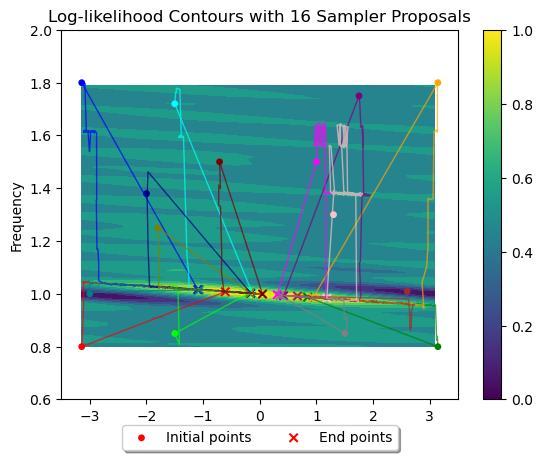

In [44]:
xp_np = np.array(x_list)  # shape (10001, 16, 2)

plt.contourf(X, Y, loglike, 10)
plt.scatter(x0, y0, color=colors,s=15, marker='o', label='Initial points')
plt.scatter(xp_np[10000,:,0], xp_np[10000,:,1], color=colors, marker='x', label='End points')

# Overlay trajectories
for i in range(xp_np.shape[1]):
    plt.plot(xp_np[:, i, 0], xp_np[:, i, 1], color=colors[i], alpha=0.7, linewidth=1)
plt.xlabel('Phase')
plt.ylabel('Frequency')
plt.title('Log-likelihood Contours with 16 Sampler Proposals')
plt.xlim([-3.5, 3.5])
plt.ylim([0.6, 2])
plt.colorbar();
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.show()

### Visualize distribution in the batch at the last time point

Should see fair samples from the toy distribution

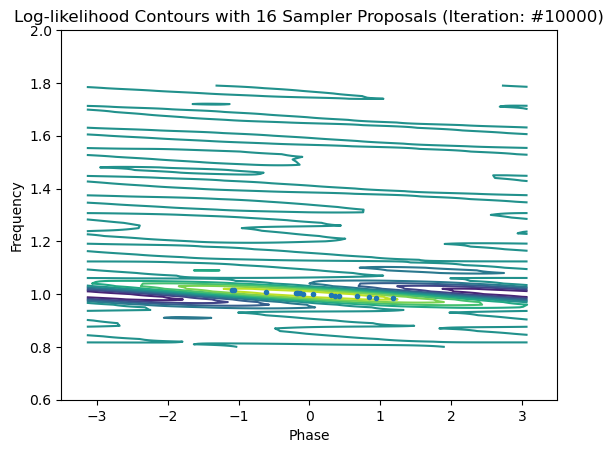

In [45]:
xp_np = x_list[-1].detach().cpu().numpy()
plt.contour(X, Y, loglike, levels=10, cmap='viridis')
plt.plot(xp_np[:,0],xp_np[:,1],'.')
plt.xlabel('Phase')
plt.ylabel('Frequency')
plt.title('Log-likelihood Contours with 16 Sampler Proposals (Iteration: #10000)')
plt.xlim([-3.5, 3.5])
plt.ylim([0.6, 2])
plt.show()

### Visualize the evolution of first dimension (horizontal axis), 

Should be a Gaussian with little correlation.

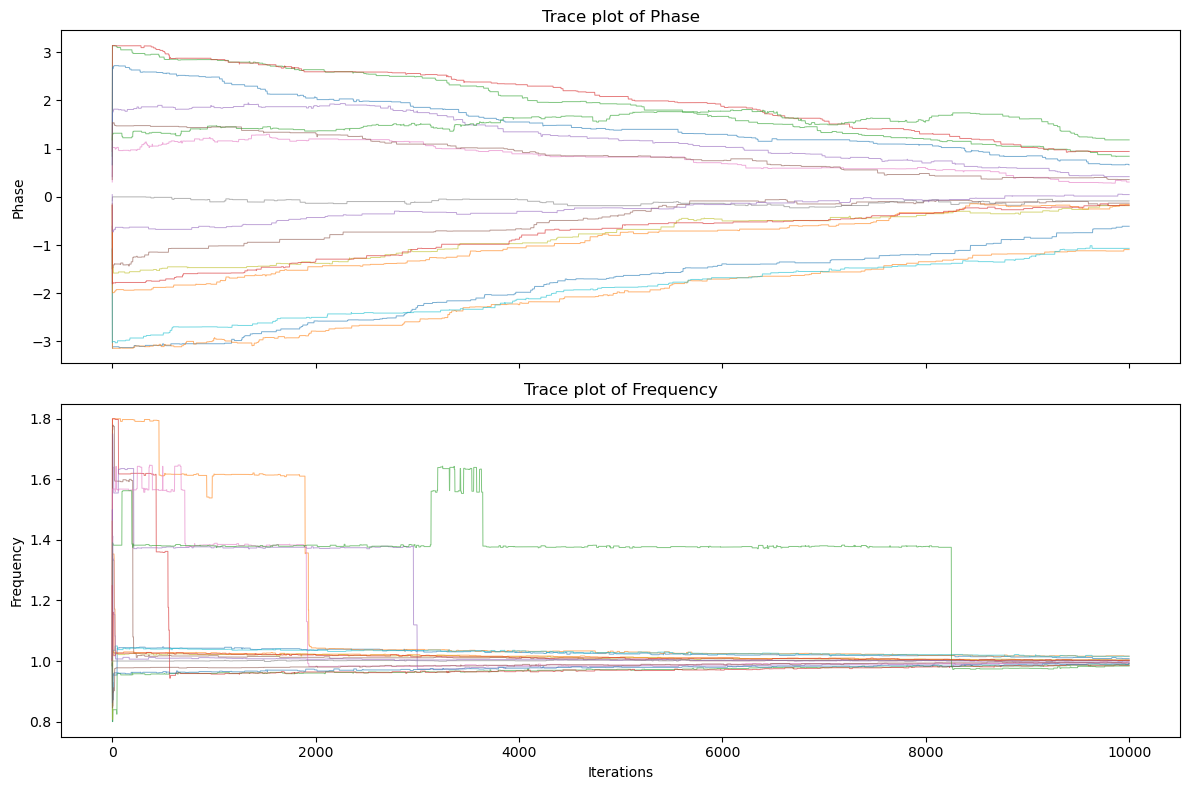

In [46]:
xp_np = np.array(x_list)
iterations = xp_np.shape[0]

param_names = ['Phase', 'Frequency']

fig, axes = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)

# Loop over each parameter (e.g., Phase and Frequency)
for param_idx in range(2):
    ax = axes[param_idx]
    for chain_idx in range(xp_np.shape[1]):
        ax.plot(
            np.arange(iterations),
            xp_np[:,chain_idx, param_idx],
            alpha=0.6,
            linewidth=0.7
        )
    ax.set_ylabel(f'{param_names[param_idx]}')
    ax.set_title(f'Trace plot of {param_names[param_idx]}')

axes[-1].set_xlabel('Iterations')

plt.tight_layout()
plt.show()

y mean 1.0280476808547974, y std 0.007746545132249594


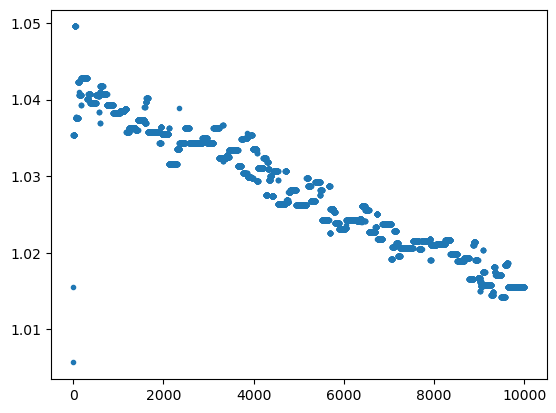

In [47]:
batch_i = 9
visualize_dim = 1 #change to 1 for the vertical axis
y_vect = torch.stack(x_list,dim=0)[0:,batch_i,visualize_dim].detach().cpu().numpy()
fig, ax = plt.subplots()
ax.plot(y_vect,'.')
y_mean, y_std = y_vect.mean(), y_vect.std()
print('y mean {}, y std {}'.format(y_mean.item(), y_std.item()))

In [48]:
# Define bin edges for histogramming
x_edges = np.linspace(-np.pi, np.pi, 101)
y_edges = np.linspace(0.8, 1.8, 101)
hist_0 = loglike

kl_divergence = []
ess = []
for i in range(len(x0)):
    # Compute histogram of post-burnin samples for KL divergence
    chain_array = np.array(x_list)  # shape: (chainlen-burnin+1, 2)
    hist_A, _, _ = np.histogram2d(chain_array[5000:,i,0], chain_array[5000:,i,1],
                                  bins=[x_edges, y_edges], density=True)
    prob_A = hist_A / np.sum(hist_A)
    prob_0 = hist_0 / np.sum(hist_0)
    prob_A_flat = prob_A.flatten() + 1e-10
    prob_0_flat = prob_0.flatten() + 1e-10
    kl_div = entropy(prob_0_flat, prob_A_flat)
    kl_divergence.append(kl_div)

    ess0 = np.array([neff(chain_array[5000:,i,k]) for k in range(2)])
    ess.append(ess0)

In [49]:
kl_divergence, ess

([13.787298833352395,
  13.795082438173335,
  13.784018226210023,
  13.784545177762507,
  13.802575414907846,
  13.81653076831747,
  13.808698705541044,
  13.820458294557117,
  13.814438036241157,
  13.789944968621775,
  13.795336667491654,
  13.804562025898523,
  13.789190120152227,
  13.812553656037661,
  13.816007590136397,
  13.808554451628694],
 [array([5.26481187, 5.67496037]),
  array([5.08598939, 5.43950402]),
  array([5.11042828, 5.42686181]),
  array([4.99120502, 5.18073423]),
  array([5.09899602, 5.53153677]),
  array([26.16772923, 29.06984128]),
  array([5.75324343, 6.55909587]),
  array([13.53563266, 25.34932935]),
  array([5.82932635, 6.6881718 ]),
  array([5.21524943, 5.8458808 ]),
  array([5.22873589, 5.54467311]),
  array([5.17969734, 5.49097087]),
  array([10.00021379,  6.63014017]),
  array([5.06406461, 6.29364009]),
  array([5.57749607, 7.52208567]),
  array([5.14691631, 5.64979322])])

In [50]:
np.nanmean(kl_divergence), np.nanmean(ess,axis=0), np.mean(np.array(accept_vect.float()))

(13.801862210939364, array([7.39060848, 8.61857621]), 0.0)

# Gaussian Mixture Model Distribution

In [4]:
# This chunk is to initial mus, covs and pis of GMM
mu_1 = torch.tensor([-5., 5.])
mu_2 = torch.tensor([5., -5.])
mu_3 = torch.tensor([5.,5.])
mu_4 = torch.tensor([-5.,-5.])
mus = torch.tensor(np.array([mu_1,mu_2,mu_3,mu_4]), dtype=torch.float32)

cov_1 = 0.9 * torch.eye(2)
cov_2 = 1.2 * torch.eye(2)
cov_3 = 0.04 * torch.tensor([[5,-4],[-4,5]])
cov_4 = 0.08* torch.tensor([[5,4],[4,5]])
covs = torch.tensor(np.array([cov_1, cov_2, cov_3, cov_4]),dtype=torch.float32)

pis = torch.tensor(np.array([0.25, 0.25, 0.25, 0.25]), dtype=torch.float32)

In [3]:
def plot_gaussian_contours(mus, covs, colors=['blue', 'red'], spacing=5,
        x_lims=[-4,4], y_lims=[-3,3], res=100):

    X = np.linspace(x_lims[0], x_lims[1], res)
    Y = np.linspace(y_lims[0], y_lims[1], res)
    X, Y = np.meshgrid(X, Y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    for i in range(len(mus)):
        mu = mus[i]
        cov = covs[i]
        F = multivariate_normal(mu, cov)
        Z = F.pdf(pos)
        plt.contour(X, Y, Z, spacing, colors=colors[0])

    return plt

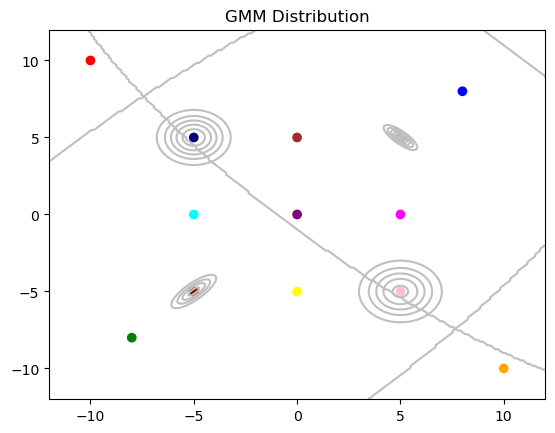

In [5]:
x0 = torch.tensor([-10.,8.,-8.,10.,0.,-5.,5.,0.,0.,-5.,5.,-5.,5.])
y0 = torch.tensor([10.,8.,-8.,-10.,0.,0.,0.,-5.,5.,5.,-5.,-5.,5.])
colors = np.array(['red','blue','green','orange','purple','cyan','magenta','yellow','brown','navy','pink','maroon','gray'])

plot_gaussian_contours(mus, covs, colors=['0.75','0.75'], x_lims=[-12,12], y_lims=[-12,12], res=200)
plt.scatter(x0,y0,c=colors)
plt.title('GMM Distribution')
plt.show()

In [76]:
data_dim = 2
dim = 32
N_steps = 2
dist = distributions('GMM',d=data_dim,mus=mus, covs=covs,pis=pis)
RW2 = L2GradRW(dist.Ex,data_dim,dim,N_steps,epsi=5,net_type='MLP',grad_mode='R',bias=True,act='elu') #diag_gaussian example use 0.001 epsi init
RW_controller2 = L2GradRW_M(RW2,beta=1e-2,beta_max=1e3,rho_beta=0.1,adapt_beta=True,a_target=0.9,
                 lr=1e-3,momo=0.9,rms_momo=0.95,grad_norm=10,N_steps=10000)

In [77]:
#train with real samples
bs = 512
for i in tqdm(range(5000)):
    x_init = dist.sample(bs)
    x, accept_rate, sldjxx, L2jump = RW_controller2.sample_train(x_init,T=1,print_log= (True if i%100==0 else False))
    #adjust_lr(RW_controller,i,warmup=False,min_lr=1e-2)
    if i>5 and i%1000 == 0:
        print('1ksteps done, now {}'.format(i))

  0%|                                                                                 | 3/5000 [00:00<11:21,  7.33it/s]

jump 9.625e+02, Exp jump0.000e+00, accept 0.000,log_a -4.406e+03, sldjxx 3.219,beta 1.000e-02, epsi 4.995e+00


  2%|█▋                                                                             | 103/5000 [00:10<07:36, 10.74it/s]

jump 2.103e+01, Exp jump4.281e-01, accept 0.168,log_a -1.034e+01, sldjxx 1.449,beta 1.000e-02, epsi 4.668e+00


  4%|███▏                                                                           | 202/5000 [00:19<08:22,  9.55it/s]

jump 2.569e+01, Exp jump4.992e-01, accept 0.166,log_a -7.183e+00, sldjxx 0.938,beta 1.000e-02, epsi 4.619e+00


  6%|████▊                                                                          | 303/5000 [00:30<07:35, 10.30it/s]

jump 2.503e+01, Exp jump4.690e-01, accept 0.212,log_a -5.565e+00, sldjxx 0.475,beta 1.000e-02, epsi 4.603e+00


  8%|██████▎                                                                        | 403/5000 [00:40<07:25, 10.33it/s]

jump 2.879e+01, Exp jump9.155e-01, accept 0.220,log_a -5.434e+00, sldjxx 0.213,beta 1.000e-02, epsi 4.602e+00


 10%|███████▉                                                                       | 503/5000 [00:49<06:56, 10.80it/s]

jump 2.754e+01, Exp jump5.820e-01, accept 0.257,log_a -4.728e+00, sldjxx -0.083,beta 1.000e-02, epsi 4.606e+00


 12%|█████████▍                                                                     | 601/5000 [00:59<06:55, 10.59it/s]

jump 2.858e+01, Exp jump7.823e-01, accept 0.250,log_a -4.975e+00, sldjxx -0.155,beta 1.000e-02, epsi 4.609e+00


 14%|███████████                                                                    | 702/5000 [01:09<07:21,  9.74it/s]

jump 2.833e+01, Exp jump7.828e-01, accept 0.276,log_a -4.591e+00, sldjxx -0.220,beta 1.000e-02, epsi 4.609e+00


 16%|████████████▋                                                                  | 802/5000 [01:20<07:47,  8.98it/s]

jump 2.683e+01, Exp jump8.712e-01, accept 0.273,log_a -4.864e+00, sldjxx -0.294,beta 1.000e-02, epsi 4.613e+00


 18%|██████████████▎                                                                | 902/5000 [01:30<06:59,  9.76it/s]

jump 2.927e+01, Exp jump1.282e+00, accept 0.276,log_a -4.225e+00, sldjxx -0.409,beta 1.000e-02, epsi 4.614e+00


 20%|███████████████▋                                                              | 1002/5000 [01:41<06:52,  9.69it/s]

jump 2.880e+01, Exp jump7.908e-01, accept 0.284,log_a -4.614e+00, sldjxx -0.484,beta 1.000e-02, epsi 4.612e+00
1ksteps done, now 1000


 22%|█████████████████▏                                                            | 1102/5000 [01:51<06:30,  9.99it/s]

jump 2.784e+01, Exp jump9.974e-01, accept 0.279,log_a -3.925e+00, sldjxx -0.427,beta 1.000e-02, epsi 4.614e+00


 24%|██████████████████▊                                                           | 1202/5000 [02:01<06:16, 10.09it/s]

jump 3.006e+01, Exp jump1.883e+00, accept 0.290,log_a -3.843e+00, sldjxx -0.641,beta 1.000e-02, epsi 4.616e+00


 26%|████████████████████▎                                                         | 1302/5000 [02:11<06:35,  9.36it/s]

jump 3.124e+01, Exp jump2.205e+00, accept 0.289,log_a -3.757e+00, sldjxx -0.660,beta 1.000e-02, epsi 4.620e+00


 28%|█████████████████████▉                                                        | 1403/5000 [02:21<06:08,  9.77it/s]

jump 2.976e+01, Exp jump2.060e+00, accept 0.353,log_a -3.074e+00, sldjxx -0.953,beta 1.000e-02, epsi 4.623e+00


 30%|███████████████████████▍                                                      | 1502/5000 [02:32<06:38,  8.78it/s]

jump 2.998e+01, Exp jump4.009e+00, accept 0.336,log_a -3.199e+00, sldjxx -0.961,beta 1.000e-02, epsi 4.627e+00


 32%|████████████████████████▉                                                     | 1602/5000 [02:43<06:08,  9.21it/s]

jump 3.130e+01, Exp jump2.323e+00, accept 0.371,log_a -3.229e+00, sldjxx -1.178,beta 1.000e-02, epsi 4.623e+00


 34%|██████████████████████████▌                                                   | 1702/5000 [02:54<06:02,  9.10it/s]

jump 2.935e+01, Exp jump1.457e+00, accept 0.369,log_a -2.742e+00, sldjxx -1.108,beta 1.000e-02, epsi 4.623e+00


 36%|████████████████████████████                                                  | 1802/5000 [03:04<05:13, 10.19it/s]

jump 3.052e+01, Exp jump2.383e+00, accept 0.393,log_a -2.572e+00, sldjxx -1.143,beta 1.000e-02, epsi 4.619e+00


 38%|█████████████████████████████▋                                                | 1903/5000 [03:14<04:56, 10.44it/s]

jump 3.114e+01, Exp jump3.332e+00, accept 0.372,log_a -2.961e+00, sldjxx -1.071,beta 1.000e-02, epsi 4.620e+00


 40%|███████████████████████████████▏                                              | 2003/5000 [03:24<04:49, 10.37it/s]

jump 3.037e+01, Exp jump3.630e+00, accept 0.411,log_a -2.666e+00, sldjxx -1.225,beta 1.000e-02, epsi 4.620e+00
1ksteps done, now 2000


 42%|████████████████████████████████▊                                             | 2103/5000 [03:33<04:43, 10.21it/s]

jump 2.771e+01, Exp jump2.543e+00, accept 0.402,log_a -2.458e+00, sldjxx -1.232,beta 1.000e-02, epsi 4.616e+00


 44%|██████████████████████████████████▎                                           | 2203/5000 [03:43<04:31, 10.29it/s]

jump 3.067e+01, Exp jump4.121e+00, accept 0.397,log_a -2.564e+00, sldjxx -1.139,beta 1.000e-02, epsi 4.616e+00


 46%|███████████████████████████████████▉                                          | 2303/5000 [03:53<04:26, 10.11it/s]

jump 3.403e+01, Exp jump6.866e+00, accept 0.429,log_a -2.568e+00, sldjxx -1.122,beta 1.000e-02, epsi 4.613e+00


 48%|█████████████████████████████████████▍                                        | 2403/5000 [04:03<04:16, 10.12it/s]

jump 3.015e+01, Exp jump4.789e+00, accept 0.424,log_a -2.337e+00, sldjxx -1.189,beta 1.000e-02, epsi 4.609e+00


 50%|███████████████████████████████████████                                       | 2503/5000 [04:13<03:59, 10.44it/s]

jump 2.913e+01, Exp jump3.803e+00, accept 0.415,log_a -2.480e+00, sldjxx -1.201,beta 1.000e-02, epsi 4.607e+00


 52%|████████████████████████████████████████▌                                     | 2603/5000 [04:23<03:57, 10.10it/s]

jump 3.329e+01, Exp jump4.591e+00, accept 0.402,log_a -2.740e+00, sldjxx -1.140,beta 1.000e-02, epsi 4.607e+00


 54%|██████████████████████████████████████████▏                                   | 2703/5000 [04:32<03:45, 10.19it/s]

jump 3.170e+01, Exp jump7.757e+00, accept 0.439,log_a -2.465e+00, sldjxx -1.157,beta 1.000e-02, epsi 4.606e+00


 56%|███████████████████████████████████████████▋                                  | 2803/5000 [04:42<04:17,  8.55it/s]

jump 3.023e+01, Exp jump5.573e+00, accept 0.423,log_a -2.402e+00, sldjxx -1.217,beta 1.000e-02, epsi 4.604e+00


 58%|█████████████████████████████████████████████▎                                | 2902/5000 [04:52<03:26, 10.14it/s]

jump 3.152e+01, Exp jump6.319e+00, accept 0.445,log_a -2.330e+00, sldjxx -1.238,beta 1.000e-02, epsi 4.599e+00


 60%|██████████████████████████████████████████████▊                               | 3001/5000 [05:02<03:12, 10.38it/s]

jump 2.923e+01, Exp jump2.995e+00, accept 0.418,log_a -2.287e+00, sldjxx -1.186,beta 1.000e-02, epsi 4.598e+00
1ksteps done, now 3000


 62%|████████████████████████████████████████████████▍                             | 3103/5000 [05:12<03:07, 10.13it/s]

jump 2.950e+01, Exp jump3.288e+00, accept 0.432,log_a -2.351e+00, sldjxx -1.146,beta 1.000e-02, epsi 4.598e+00


 64%|█████████████████████████████████████████████████▉                            | 3202/5000 [05:22<03:06,  9.66it/s]

jump 3.136e+01, Exp jump6.262e+00, accept 0.420,log_a -2.213e+00, sldjxx -1.154,beta 1.000e-02, epsi 4.597e+00


 66%|███████████████████████████████████████████████████▌                          | 3302/5000 [05:32<02:46, 10.20it/s]

jump 3.054e+01, Exp jump5.395e+00, accept 0.442,log_a -2.281e+00, sldjxx -1.246,beta 1.000e-02, epsi 4.596e+00


 68%|█████████████████████████████████████████████████████                         | 3402/5000 [05:42<02:39, 10.04it/s]

jump 3.056e+01, Exp jump5.564e+00, accept 0.428,log_a -2.089e+00, sldjxx -1.326,beta 1.000e-02, epsi 4.596e+00


 70%|██████████████████████████████████████████████████████▋                       | 3502/5000 [05:52<02:27, 10.18it/s]

jump 3.205e+01, Exp jump6.560e+00, accept 0.451,log_a -2.139e+00, sldjxx -1.224,beta 1.000e-02, epsi 4.600e+00


 72%|████████████████████████████████████████████████████████▏                     | 3603/5000 [06:02<02:16, 10.23it/s]

jump 2.958e+01, Exp jump5.268e+00, accept 0.429,log_a -2.074e+00, sldjxx -1.243,beta 1.000e-02, epsi 4.593e+00


 74%|█████████████████████████████████████████████████████████▊                    | 3703/5000 [06:11<02:08, 10.10it/s]

jump 3.110e+01, Exp jump6.236e+00, accept 0.448,log_a -2.082e+00, sldjxx -1.286,beta 1.000e-02, epsi 4.593e+00


 76%|███████████████████████████████████████████████████████████▎                  | 3803/5000 [06:21<01:59, 10.01it/s]

jump 3.338e+01, Exp jump1.037e+01, accept 0.453,log_a -2.299e+00, sldjxx -1.336,beta 1.000e-02, epsi 4.591e+00


 78%|████████████████████████████████████████████████████████████▉                 | 3903/5000 [06:31<01:48, 10.07it/s]

jump 3.251e+01, Exp jump9.434e+00, accept 0.452,log_a -2.050e+00, sldjxx -1.377,beta 1.000e-02, epsi 4.590e+00


 80%|██████████████████████████████████████████████████████████████▍               | 4002/5000 [06:41<01:42,  9.75it/s]

jump 3.384e+01, Exp jump8.430e+00, accept 0.439,log_a -2.010e+00, sldjxx -1.363,beta 1.000e-02, epsi 4.590e+00
1ksteps done, now 4000


 82%|███████████████████████████████████████████████████████████████▉              | 4102/5000 [06:52<01:33,  9.63it/s]

jump 3.466e+01, Exp jump1.122e+01, accept 0.487,log_a -1.866e+00, sldjxx -1.516,beta 1.000e-02, epsi 4.593e+00


 84%|█████████████████████████████████████████████████████████████████▌            | 4203/5000 [07:02<01:17, 10.26it/s]

jump 3.498e+01, Exp jump1.183e+01, accept 0.435,log_a -1.903e+00, sldjxx -1.558,beta 1.000e-02, epsi 4.594e+00


 86%|███████████████████████████████████████████████████████████████████           | 4301/5000 [07:12<01:08, 10.23it/s]

jump 3.441e+01, Exp jump1.227e+01, accept 0.478,log_a -2.195e+00, sldjxx -1.569,beta 1.000e-02, epsi 4.593e+00


 88%|████████████████████████████████████████████████████████████████████▋         | 4403/5000 [07:22<01:01,  9.66it/s]

jump 3.855e+01, Exp jump1.471e+01, accept 0.453,log_a -2.280e+00, sldjxx -1.554,beta 1.000e-02, epsi 4.587e+00


 90%|██████████████████████████████████████████████████████████████████████▏       | 4503/5000 [07:32<00:48, 10.35it/s]

jump 3.865e+01, Exp jump1.475e+01, accept 0.474,log_a -2.122e+00, sldjxx -1.637,beta 1.000e-02, epsi 4.588e+00


 92%|███████████████████████████████████████████████████████████████████████▊      | 4603/5000 [07:41<00:37, 10.45it/s]

jump 3.641e+01, Exp jump1.359e+01, accept 0.519,log_a -1.775e+00, sldjxx -1.618,beta 1.000e-02, epsi 4.593e+00


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4702/5000 [07:51<00:29, 10.14it/s]

jump 3.855e+01, Exp jump1.755e+01, accept 0.519,log_a -1.630e+00, sldjxx -1.641,beta 1.000e-02, epsi 4.588e+00


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4803/5000 [08:01<00:19, 10.11it/s]

jump 3.743e+01, Exp jump1.415e+01, accept 0.453,log_a -1.887e+00, sldjxx -1.605,beta 1.000e-02, epsi 4.594e+00


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4902/5000 [08:11<00:09, 10.31it/s]

jump 3.696e+01, Exp jump1.578e+01, accept 0.494,log_a -1.864e+00, sldjxx -1.572,beta 1.000e-02, epsi 4.583e+00


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [08:20<00:00,  9.99it/s]


In [78]:
x = torch.tensor(np.array([x0,y0])).T
#bs = 10
#x = dist.sample(bs)

x_list2 = []
x_list2.append(x.clone())
for i in tqdm(range(10000)):
    x,xp,accept_vect,_ = RW_controller2.sample(x,1,grad=False,print_log= True if i%1000==0 else False,)
    x_list2.append(x.clone())

  0%|                                                                                | 8/10000 [00:00<04:38, 35.87it/s]

accept 0.38461539149284363


 10%|███████▋                                                                     | 1006/10000 [00:25<04:14, 35.37it/s]

accept 0.3076923191547394


 20%|███████████████▍                                                             | 2007/10000 [00:51<03:46, 35.25it/s]

accept 0.5384615659713745


 30%|███████████████████████▏                                                     | 3006/10000 [01:16<02:45, 42.32it/s]

accept 0.38461539149284363


 40%|██████████████████████████████▊                                              | 4006/10000 [01:41<02:36, 38.24it/s]

accept 0.38461539149284363


 50%|██████████████████████████████████████▌                                      | 5007/10000 [02:06<02:05, 39.73it/s]

accept 0.3076923191547394


 60%|██████████████████████████████████████████████▎                              | 6008/10000 [02:30<01:33, 42.56it/s]

accept 0.4615384638309479


 70%|█████████████████████████████████████████████████████▉                       | 7008/10000 [02:54<01:09, 42.91it/s]

accept 0.5384615659713745


 80%|█████████████████████████████████████████████████████████████▋               | 8008/10000 [03:17<00:45, 44.12it/s]

accept 0.6153846383094788


 90%|█████████████████████████████████████████████████████████████████████▎       | 9009/10000 [03:40<00:22, 43.93it/s]

accept 0.4615384638309479


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:04<00:00, 40.90it/s]


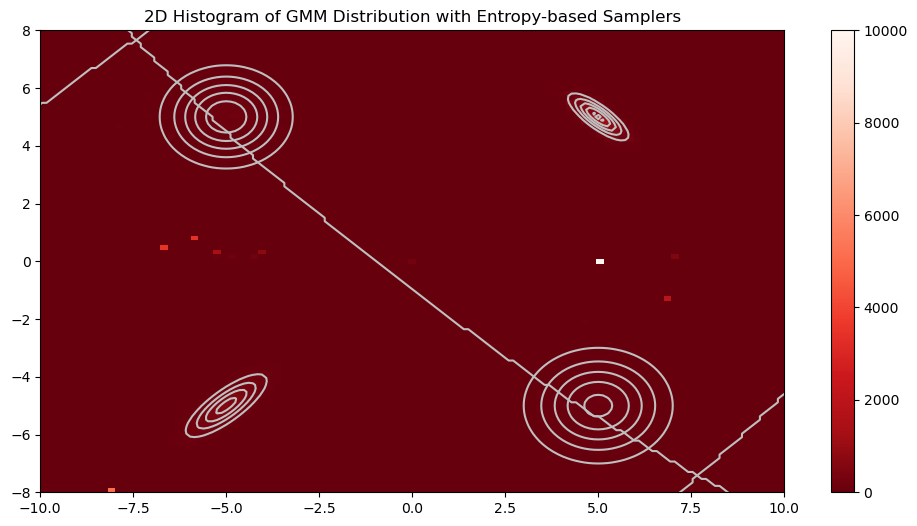

In [79]:
c_contour = '0.75'
theory = dist.sample(10000)
x_try2 = np.array(x_list2)
plt.figure(figsize=(12, 6))
x_edges = np.linspace(-10,10,int(np.sqrt(10000)))
y_edges = np.linspace(-8,8,int(np.sqrt(10000)))

plot_gaussian_contours(mus, covs, colors=[c_contour, c_contour], x_lims=[-12,12], y_lims=[-12,12], res=200)
plt.hist2d(x_try2[:,:,0].flatten(), x_try2[:,:,1].flatten(), bins=[x_edges, y_edges], cmap=plt.cm.Reds_r)
plt.colorbar()
plt.title('2D Histogram of GMM Distribution with Entropy-based Samplers')
plt.show()

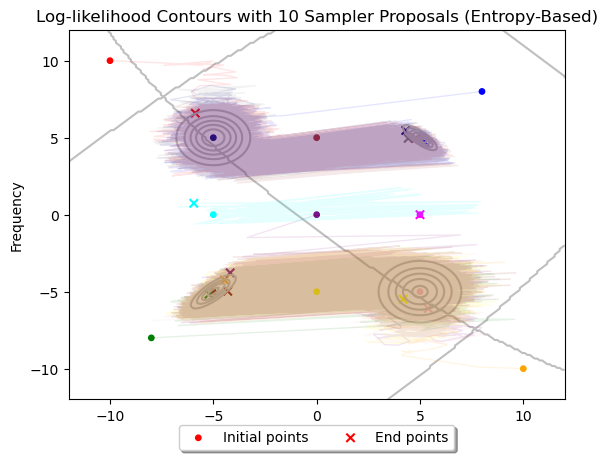

In [80]:
c_true, c_contour = 'purple', '0.75'
xp_np2 = np.array(x_list2)
plot_gaussian_contours(mus, covs, colors=[c_contour, c_contour], x_lims=[-12,12], y_lims=[-12,12], res=200)
plt.scatter(x0, y0, color=colors,s=15, marker='o', label='Initial points')
plt.scatter(xp_np2[10000,:,0], xp_np2[10000,:,1], color=colors, marker='x', label='End points')

# Overlay trajectories
for i in range(xp_np2.shape[1]):
    plt.plot(xp_np2[:, i, 0], xp_np2[:, i, 1], color=colors[i], alpha=0.1, linewidth=1)

plt.xlabel('Phase')
plt.ylabel('Frequency')
plt.title('Log-likelihood Contours with 10 Sampler Proposals (Entropy-Based)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.show()

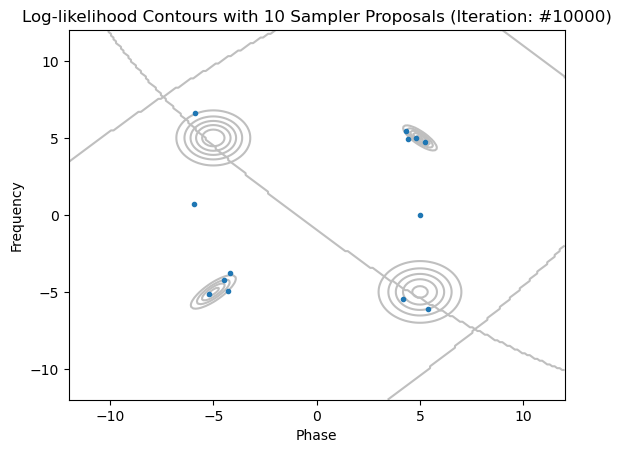

In [81]:
xp_np2 = x_list2[-1].detach().cpu().numpy()
plot_gaussian_contours(mus, covs, colors=[c_contour, c_contour], x_lims=[-12,12], y_lims=[-12,12], res=200)
plt.plot(xp_np2[:,0],xp_np2[:,1],'.')
plt.xlabel('Phase')
plt.ylabel('Frequency')
plt.title('Log-likelihood Contours with 10 Sampler Proposals (Iteration: #10000)')
plt.show()

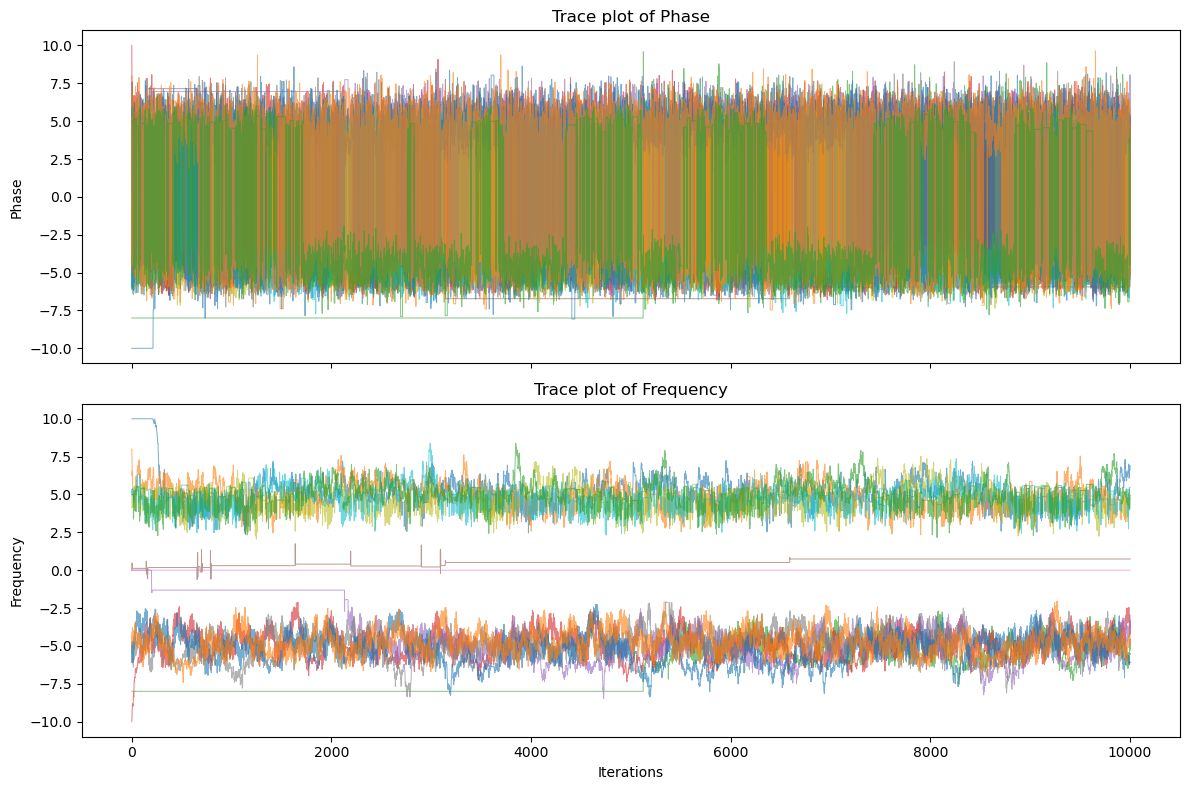

In [82]:
xp_np2 = np.array(x_list2)
iterations = xp_np2.shape[0]

param_names = ['Phase', 'Frequency']

fig, axes = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)

# Loop over each parameter (e.g., Phase and Frequency)
for param_idx in range(2):
    ax = axes[param_idx]
    for chain_idx in range(xp_np2.shape[1]):
        ax.plot(
            np.arange(iterations),
            xp_np2[:,chain_idx, param_idx],
            alpha=0.6,
            linewidth=0.7
        )
    ax.set_ylabel(f'{param_names[param_idx]}')
    ax.set_title(f'Trace plot of {param_names[param_idx]}')

axes[-1].set_xlabel('Iterations')

plt.tight_layout()
plt.show()

In [83]:
# Define bin edges for histogramming
hist_0, _, _ = np.histogram2d(theory[:, 0], theory[:, 1], bins=[x_edges, y_edges], density=True)

kl_divergence2 = []
ess2 = []
for i in range(len(colors)):
    # Compute histogram of post-burnin samples for KL divergence
    chain_array = np.array(x_list2)  # shape: (chainlen-burnin+1, 2)
    hist_A, _, _ = np.histogram2d(chain_array[5000:,i,0], chain_array[5000:,i,1],
                                  bins=[x_edges, y_edges], density=True)
    prob_A = hist_A / np.sum(hist_A)
    prob_0 = hist_0 / np.sum(hist_0)
    prob_A_flat = prob_A.flatten() + 1e-10
    prob_0_flat = prob_0.flatten() + 1e-10
    kl_div = entropy(prob_0_flat, prob_A_flat)
    kl_divergence2.append(kl_div)

    ess0 = np.array([neff(chain_array[5000:,i,k]) for k in range(2)])
    ess2.append(ess0)

In [84]:
kl_divergence2, ess2

([9.70350487486389,
  8.917542562280445,
  8.654011571063648,
  8.722016486675946,
  8.673110616516176,
  16.357964027918708,
  16.357964031519288,
  8.716945852162164,
  9.14549714289011,
  8.97646268548038,
  8.920978175953294,
  9.05746266920641,
  8.731319920254828],
 [array([ 39.3559115 , 172.47423962]),
  array([174.2072934 , 307.09822543]),
  array([818.97005347, 141.17660544]),
  array([255.13034503,  87.35409581]),
  array([251.98902177, 134.49285649]),
  array([9.12250332, 6.91969111]),
  array([nan, nan]),
  array([239.00481961,  43.91980387]),
  array([ 43.55433585, 178.37440496]),
  array([121.81921129, 620.79340094]),
  array([31.26126262, 14.1362257 ]),
  array([1405.04703906,  106.94754518]),
  array([195.71375884, 429.4949102 ])])

In [85]:
np.nanmean(kl_divergence2), np.nanmean(ess2,axis=0), np.mean(np.array(accept_vect.float()))

(10.071906201291178, array([298.76462965, 186.93183373]), 0.53846157)

# Moon Distribution

In [3]:
x0 = torch.tensor([-0.2763, -0.5227, 0.2667, 1.1608, -0.0107, -0.5375, -0.1518, -0.4553, -0.2056, 2.0992])
y0 = torch.tensor([0.9025, -0.8384, -0.4792, -0.3755, -0.5761, 1.2326, 1.1072, 1.2231, 0.4552, 0.6527])
colors = np.array(['red','blue','green','orange','purple','yellow','brown','navy','pink','gray'])


In [4]:
Z0 = torch.tensor(np.array([x0,y0])).T

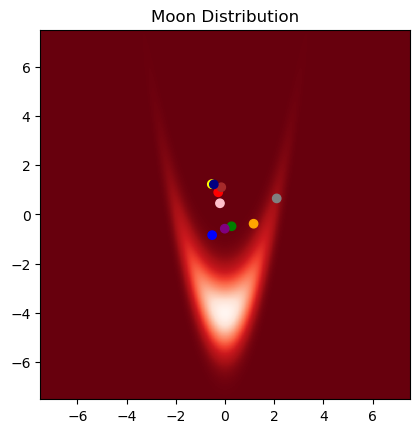

In [5]:
def npdensity(z):
    z = np.reshape(z, [z.shape[0], 2])
    z1, z2 = z[:, 0], z[:, 1]
    E_y = z1**2/2
    E_x = (z2 - z1**2 + 4)**2/2
    return np.exp(-(E_y+E_x))

r = np.linspace(-7.5, 7.5, 1000)
x, y = np.meshgrid(r, r)
z = np.vstack([x.flatten(), y.flatten()]).T

q0 = npdensity(z)
plt.pcolormesh(x, y, q0.reshape(x.shape),
                           cmap=plt.cm.Reds_r)
plt.scatter(Z0[:,0],Z0[:,1], color=colors)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Moon Distribution')
plt.show()

In [6]:
# For moon contour plot later on
x_edges = np.linspace(-4,4,int(np.sqrt(10000)))
y_edges = np.linspace(-7,5,int(np.sqrt(10000)))
X, Y = np.meshgrid(x_edges, y_edges)

grid_points = np.vstack([X.ravel(), Y.ravel()]).T
grid_tensor = torch.from_numpy(grid_points.astype(np.float32))
with torch.no_grad():
    Z = npdensity(grid_tensor).numpy().reshape(X.shape)

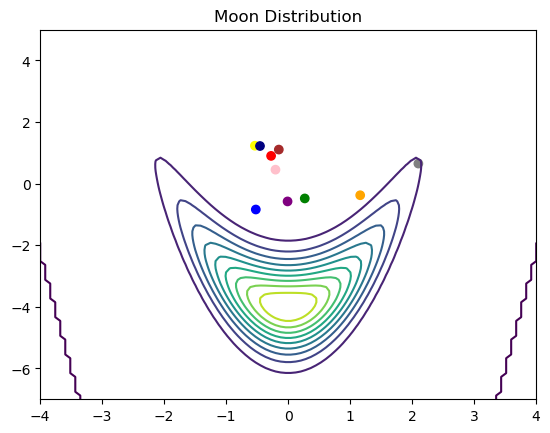

In [7]:
plt.contour(X,Y,Z, levels=10)
plt.scatter(Z0[:,0],Z0[:,1], color=colors)
plt.title('Moon Distribution')
plt.show()

In [89]:
data_dim = 2
dim = 32
N_steps = 2
dist = distributions('moon',d=data_dim)
RW = L2GradRW(dist.Ex,data_dim,dim,N_steps,epsi=1,net_type='MLP',grad_mode='R',bias=True,act='elu') #diag_gaussian example use 0.001 epsi init
RW_controller3 = L2GradRW_M(RW,beta=1e-2,beta_max=1e3,rho_beta=0.1,adapt_beta=True,a_target=0.9,
                 lr=1e-3,momo=0.9,rms_momo=0.95,grad_norm=10,N_steps=10000)

In [90]:
#train with real samples
bs = 512
for i in tqdm(range(5000)):
    x_init = dist.sample(bs)
    x, accept_rate, sldjxx, L2jump = RW_controller3.sample_train(x_init,T=1,print_log= (True if i%100==0 else False))
    #adjust_lr(RW_controller,i,warmup=False,min_lr=1e-2)
    if i>5 and i%1000 == 0:
        print('1ksteps done, now {}'.format(i))

  0%|                                                                                 | 4/5000 [00:00<05:07, 16.27it/s]

jump 1.898e+00, Exp jump4.134e-01, accept 0.468,log_a -5.679e+02, sldjxx 0.000,beta 1.000e-02, epsi 9.990e-01


  2%|█▋                                                                             | 104/5000 [00:06<05:10, 15.74it/s]

jump 1.671e-01, Exp jump1.406e-01, accept 0.916,log_a -1.127e-01, sldjxx -2.013,beta 1.020e-02, epsi 9.349e-01


  4%|███▏                                                                           | 202/5000 [00:13<05:14, 15.25it/s]

jump 1.207e-01, Exp jump1.179e-01, accept 0.982,log_a -1.468e-02, sldjxx -2.258,beta 1.999e-02, epsi 9.318e-01


  6%|████▊                                                                          | 304/5000 [00:19<04:58, 15.72it/s]

jump 1.837e-01, Exp jump1.777e-01, accept 0.991,log_a 6.299e-03, sldjxx -2.048,beta 4.737e-02, epsi 9.317e-01


  8%|██████▍                                                                        | 404/5000 [00:26<04:54, 15.59it/s]

jump 3.258e-01, Exp jump3.178e-01, accept 0.985,log_a -7.523e-04, sldjxx -1.690,beta 1.117e-01, epsi 9.323e-01


 10%|███████▉                                                                       | 504/5000 [00:32<04:46, 15.69it/s]

jump 5.616e-01, Exp jump5.377e-01, accept 0.973,log_a -4.964e-03, sldjxx -1.229,beta 2.373e-01, epsi 9.338e-01


 12%|█████████▌                                                                     | 604/5000 [00:39<04:40, 15.69it/s]

jump 1.015e+00, Exp jump8.792e-01, accept 0.936,log_a -5.802e-02, sldjxx -0.833,beta 3.855e-01, epsi 9.350e-01


 14%|███████████                                                                    | 704/5000 [00:45<04:30, 15.85it/s]

jump 1.345e+00, Exp jump1.111e+00, accept 0.927,log_a -7.420e-02, sldjxx -0.518,beta 5.127e-01, epsi 9.358e-01


 16%|████████████▋                                                                  | 802/5000 [00:52<05:28, 12.77it/s]

jump 2.038e+00, Exp jump1.582e+00, accept 0.895,log_a -7.890e-02, sldjxx -0.222,beta 5.371e-01, epsi 9.370e-01


 18%|██████████████▎                                                                | 904/5000 [00:59<04:24, 15.47it/s]

jump 2.764e+00, Exp jump2.373e+00, accept 0.913,log_a -5.073e-02, sldjxx -0.091,beta 5.445e-01, epsi 9.383e-01


 20%|███████████████▋                                                              | 1002/5000 [01:05<04:12, 15.81it/s]

jump 3.704e+00, Exp jump3.166e+00, accept 0.926,log_a -2.644e-02, sldjxx 0.037,beta 5.854e-01, epsi 9.395e-01
1ksteps done, now 1000


 22%|█████████████████▏                                                            | 1104/5000 [01:12<04:18, 15.05it/s]

jump 5.682e+00, Exp jump3.830e+00, accept 0.889,log_a -1.007e-01, sldjxx 0.104,beta 6.217e-01, epsi 9.398e-01


 24%|██████████████████▊                                                           | 1204/5000 [01:18<04:03, 15.60it/s]

jump 4.625e+00, Exp jump3.533e+00, accept 0.907,log_a -5.731e-02, sldjxx 0.133,beta 6.549e-01, epsi 9.402e-01


 26%|████████████████████▎                                                         | 1304/5000 [01:25<03:57, 15.55it/s]

jump 4.753e+00, Exp jump3.912e+00, accept 0.899,log_a -6.554e-02, sldjxx 0.181,beta 6.774e-01, epsi 9.404e-01


 28%|█████████████████████▊                                                        | 1402/5000 [01:32<04:18, 13.94it/s]

jump 4.856e+00, Exp jump3.773e+00, accept 0.902,log_a -8.446e-02, sldjxx 0.188,beta 6.871e-01, epsi 9.405e-01


 30%|███████████████████████▍                                                      | 1504/5000 [01:39<03:52, 15.01it/s]

jump 5.271e+00, Exp jump3.807e+00, accept 0.894,log_a -6.166e-02, sldjxx 0.234,beta 6.935e-01, epsi 9.407e-01


 32%|████████████████████████▉                                                     | 1602/5000 [01:45<03:37, 15.62it/s]

jump 5.086e+00, Exp jump3.515e+00, accept 0.889,log_a -8.266e-02, sldjxx 0.241,beta 7.032e-01, epsi 9.409e-01


 34%|██████████████████████████▌                                                   | 1704/5000 [01:52<03:48, 14.44it/s]

jump 6.187e+00, Exp jump4.057e+00, accept 0.908,log_a -5.816e-02, sldjxx 0.217,beta 7.081e-01, epsi 9.409e-01


 36%|████████████████████████████▏                                                 | 1804/5000 [01:59<03:25, 15.55it/s]

jump 5.284e+00, Exp jump3.973e+00, accept 0.905,log_a -6.286e-02, sldjxx 0.223,beta 7.157e-01, epsi 9.410e-01


 38%|█████████████████████████████▋                                                | 1902/5000 [02:05<03:32, 14.59it/s]

jump 4.637e+00, Exp jump3.758e+00, accept 0.921,log_a -2.516e-02, sldjxx 0.218,beta 7.148e-01, epsi 9.410e-01


 40%|███████████████████████████████▎                                              | 2004/5000 [02:12<03:11, 15.61it/s]

jump 6.228e+00, Exp jump3.895e+00, accept 0.907,log_a -5.895e-02, sldjxx 0.219,beta 7.117e-01, epsi 9.410e-01
1ksteps done, now 2000


 42%|████████████████████████████████▊                                             | 2104/5000 [02:18<03:16, 14.75it/s]

jump 5.487e+00, Exp jump3.593e+00, accept 0.894,log_a -8.659e-02, sldjxx 0.250,beta 7.346e-01, epsi 9.410e-01


 44%|██████████████████████████████████▎                                           | 2202/5000 [02:25<03:09, 14.77it/s]

jump 6.705e+00, Exp jump4.620e+00, accept 0.903,log_a -8.230e-02, sldjxx 0.221,beta 7.348e-01, epsi 9.410e-01


 46%|███████████████████████████████████▉                                          | 2304/5000 [02:32<02:54, 15.41it/s]

jump 5.437e+00, Exp jump4.017e+00, accept 0.919,log_a -5.791e-02, sldjxx 0.219,beta 7.263e-01, epsi 9.410e-01


 48%|█████████████████████████████████████▌                                        | 2404/5000 [02:38<02:51, 15.13it/s]

jump 4.779e+00, Exp jump3.462e+00, accept 0.909,log_a -5.632e-02, sldjxx 0.250,beta 7.338e-01, epsi 9.411e-01


 50%|███████████████████████████████████████                                       | 2504/5000 [02:45<02:44, 15.16it/s]

jump 5.070e+00, Exp jump3.281e+00, accept 0.910,log_a -7.507e-02, sldjxx 0.232,beta 7.288e-01, epsi 9.410e-01


 52%|████████████████████████████████████████▌                                     | 2604/5000 [02:51<02:33, 15.60it/s]

jump 5.615e+00, Exp jump3.576e+00, accept 0.907,log_a -6.150e-02, sldjxx 0.232,beta 7.353e-01, epsi 9.410e-01


 54%|██████████████████████████████████████████▏                                   | 2702/5000 [02:58<02:29, 15.39it/s]

jump 6.412e+00, Exp jump4.610e+00, accept 0.894,log_a -6.343e-02, sldjxx 0.253,beta 7.403e-01, epsi 9.410e-01


 56%|███████████████████████████████████████████▋                                  | 2804/5000 [03:04<02:28, 14.78it/s]

jump 5.204e+00, Exp jump3.560e+00, accept 0.897,log_a -8.551e-02, sldjxx 0.261,beta 7.381e-01, epsi 9.410e-01


 58%|█████████████████████████████████████████████▎                                | 2904/5000 [03:11<02:15, 15.50it/s]

jump 4.967e+00, Exp jump3.325e+00, accept 0.893,log_a -7.824e-02, sldjxx 0.259,beta 7.402e-01, epsi 9.409e-01


 60%|██████████████████████████████████████████████▊                               | 3004/5000 [03:18<02:06, 15.74it/s]

jump 5.573e+00, Exp jump3.663e+00, accept 0.890,log_a -9.194e-02, sldjxx 0.265,beta 7.327e-01, epsi 9.410e-01
1ksteps done, now 3000


 62%|████████████████████████████████████████████████▍                             | 3104/5000 [03:24<02:01, 15.55it/s]

jump 5.854e+00, Exp jump3.920e+00, accept 0.892,log_a -7.734e-02, sldjxx 0.261,beta 7.465e-01, epsi 9.409e-01


 64%|█████████████████████████████████████████████████▉                            | 3204/5000 [03:31<01:55, 15.60it/s]

jump 5.653e+00, Exp jump3.839e+00, accept 0.892,log_a -7.488e-02, sldjxx 0.260,beta 7.343e-01, epsi 9.408e-01


 66%|███████████████████████████████████████████████████▌                          | 3302/5000 [03:37<01:51, 15.24it/s]

jump 5.072e+00, Exp jump3.830e+00, accept 0.906,log_a -6.384e-02, sldjxx 0.234,beta 7.375e-01, epsi 9.408e-01


 68%|█████████████████████████████████████████████████████                         | 3402/5000 [03:44<01:43, 15.50it/s]

jump 6.395e+00, Exp jump4.257e+00, accept 0.901,log_a -6.975e-02, sldjxx 0.243,beta 7.370e-01, epsi 9.408e-01


 70%|██████████████████████████████████████████████████████▋                       | 3504/5000 [03:50<01:34, 15.91it/s]

jump 5.829e+00, Exp jump3.469e+00, accept 0.902,log_a -8.691e-02, sldjxx 0.238,beta 7.324e-01, epsi 9.408e-01


 72%|████████████████████████████████████████████████████████▏                     | 3604/5000 [03:57<01:31, 15.19it/s]

jump 6.732e+00, Exp jump3.767e+00, accept 0.892,log_a -1.150e-01, sldjxx 0.246,beta 7.340e-01, epsi 9.408e-01


 74%|█████████████████████████████████████████████████████████▊                    | 3704/5000 [04:04<01:22, 15.66it/s]

jump 5.955e+00, Exp jump4.217e+00, accept 0.893,log_a -7.375e-02, sldjxx 0.270,beta 7.403e-01, epsi 9.408e-01


 76%|███████████████████████████████████████████████████████████▎                  | 3804/5000 [04:10<01:21, 14.68it/s]

jump 5.737e+00, Exp jump4.477e+00, accept 0.903,log_a -5.017e-02, sldjxx 0.249,beta 7.332e-01, epsi 9.407e-01


 78%|████████████████████████████████████████████████████████████▊                 | 3902/5000 [04:17<01:13, 15.02it/s]

jump 5.238e+00, Exp jump3.922e+00, accept 0.911,log_a -6.518e-02, sldjxx 0.234,beta 7.384e-01, epsi 9.407e-01


 80%|██████████████████████████████████████████████████████████████▍               | 4004/5000 [04:24<01:04, 15.50it/s]

jump 5.578e+00, Exp jump3.890e+00, accept 0.909,log_a -6.484e-02, sldjxx 0.232,beta 7.424e-01, epsi 9.407e-01
1ksteps done, now 4000


 82%|███████████████████████████████████████████████████████████████▉              | 4102/5000 [04:30<00:58, 15.24it/s]

jump 5.241e+00, Exp jump3.711e+00, accept 0.897,log_a -6.927e-02, sldjxx 0.257,beta 7.324e-01, epsi 9.406e-01


 84%|█████████████████████████████████████████████████████████████████▌            | 4204/5000 [04:37<00:52, 15.09it/s]

jump 5.603e+00, Exp jump3.710e+00, accept 0.879,log_a -9.938e-02, sldjxx 0.291,beta 7.455e-01, epsi 9.407e-01


 86%|███████████████████████████████████████████████████████████████████▏          | 4304/5000 [04:44<00:44, 15.63it/s]

jump 6.592e+00, Exp jump4.280e+00, accept 0.889,log_a -7.468e-02, sldjxx 0.255,beta 7.363e-01, epsi 9.406e-01


 88%|████████████████████████████████████████████████████████████████████▋         | 4404/5000 [04:50<00:39, 15.20it/s]

jump 5.244e+00, Exp jump4.212e+00, accept 0.918,log_a -4.543e-02, sldjxx 0.230,beta 7.439e-01, epsi 9.405e-01


 90%|██████████████████████████████████████████████████████████████████████▎       | 4504/5000 [04:57<00:32, 15.29it/s]

jump 6.666e+00, Exp jump4.289e+00, accept 0.900,log_a -7.537e-02, sldjxx 0.229,beta 7.325e-01, epsi 9.405e-01


 92%|███████████████████████████████████████████████████████████████████████▊      | 4604/5000 [05:03<00:25, 15.48it/s]

jump 4.734e+00, Exp jump3.371e+00, accept 0.916,log_a -5.152e-02, sldjxx 0.242,beta 7.425e-01, epsi 9.405e-01


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4702/5000 [05:10<00:19, 15.37it/s]

jump 6.644e+00, Exp jump4.762e+00, accept 0.898,log_a -7.926e-02, sldjxx 0.267,beta 7.437e-01, epsi 9.404e-01


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4804/5000 [05:17<00:13, 14.67it/s]

jump 4.508e+00, Exp jump3.432e+00, accept 0.907,log_a -6.029e-02, sldjxx 0.264,beta 7.384e-01, epsi 9.405e-01


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4902/5000 [05:24<00:06, 14.86it/s]

jump 6.184e+00, Exp jump4.482e+00, accept 0.919,log_a -5.301e-02, sldjxx 0.239,beta 7.424e-01, epsi 9.405e-01


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [05:30<00:00, 15.13it/s]


In [91]:
#bs = 1024
x = Z0
x_list3 = []
for i in tqdm(range(10000)):
    x,xp,accept_vect,_ = RW_controller3.sample(x,1,grad=False,print_log= True if i%1000==0 else False,)
    x_list3.append(x.clone())

  0%|▏                                                                              | 17/10000 [00:00<02:03, 81.08it/s]

accept 1.0


 10%|███████▊                                                                     | 1011/10000 [00:11<01:37, 91.91it/s]

accept 0.8999999761581421


 20%|███████████████▌                                                             | 2015/10000 [00:23<01:26, 92.30it/s]

accept 0.800000011920929


 30%|███████████████████████▏                                                     | 3016/10000 [00:34<01:15, 92.71it/s]

accept 1.0


 40%|██████████████████████████████▉                                              | 4015/10000 [00:45<01:04, 92.23it/s]

accept 0.8999999761581421


 50%|██████████████████████████████████████▌                                      | 5015/10000 [00:56<00:55, 90.54it/s]

accept 0.699999988079071


 60%|██████████████████████████████████████████████▎                              | 6016/10000 [01:08<00:44, 88.60it/s]

accept 1.0


 70%|█████████████████████████████████████████████████████▉                       | 7010/10000 [01:20<00:37, 78.81it/s]

accept 1.0


 80%|█████████████████████████████████████████████████████████████▋               | 8017/10000 [01:32<00:22, 88.26it/s]

accept 1.0


 90%|█████████████████████████████████████████████████████████████████████▍       | 9017/10000 [01:43<00:10, 94.65it/s]

accept 1.0


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:54<00:00, 87.50it/s]


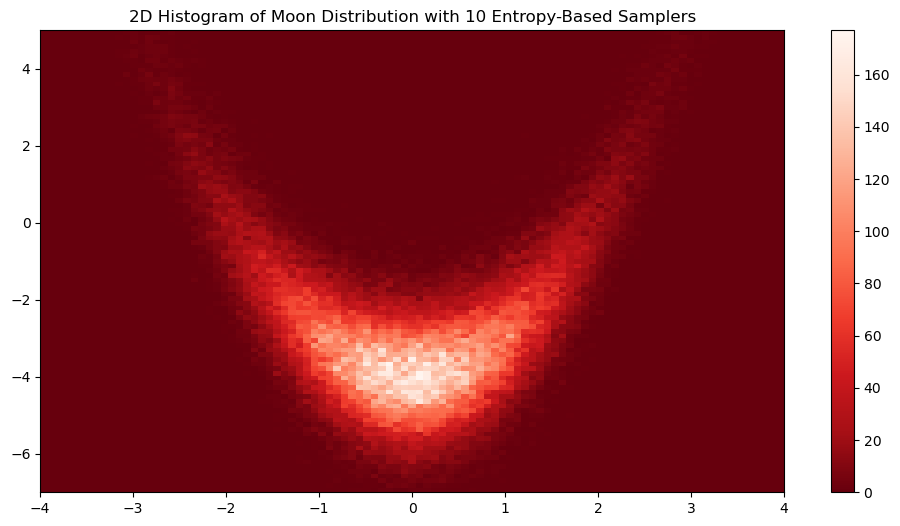

In [92]:
c_contour = '0.75'
theory = dist.sample(10000)
x_try3 = np.array(x_list3)
plt.figure(figsize=(12, 6))
x_edges = np.linspace(-4,4,int(np.sqrt(10000)))
y_edges = np.linspace(-7,5,int(np.sqrt(10000)))

#plot_gaussian_contours(mus, covs, colors=[c_contour, c_contour], x_lims=[-12,12], y_lims=[-12,12], res=200)
plt.hist2d(x_try3[:,:,0].flatten(), x_try3[:,:,1].flatten(), bins=[x_edges, y_edges], cmap=plt.cm.Reds_r)
plt.colorbar()
plt.title('2D Histogram of Moon Distribution with 10 Entropy-Based Samplers')
plt.show()

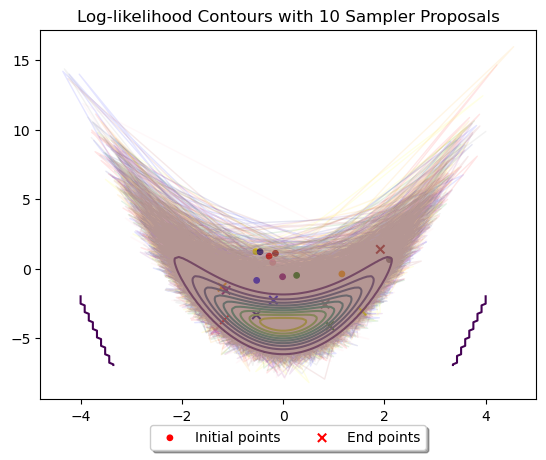

In [93]:
c_true, c_contour = 'purple', '0.75'
xp_np3 = np.array(x_list3)
plt.contour(X,Y,Z, levels=10)
plt.scatter(x0, y0, color=colors,s=15, marker='o', label='Initial points')
plt.scatter(xp_np3[9999,:,0], xp_np3[9999,:,1], color=colors,marker='x', label='End points')

# Overlay trajectories
for i in range(xp_np3.shape[1]):
    plt.plot(xp_np3[:, i, 0], xp_np3[:, i, 1], color=colors[i], alpha=0.1, linewidth=1)


plt.title('Log-likelihood Contours with 10 Sampler Proposals')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.show()

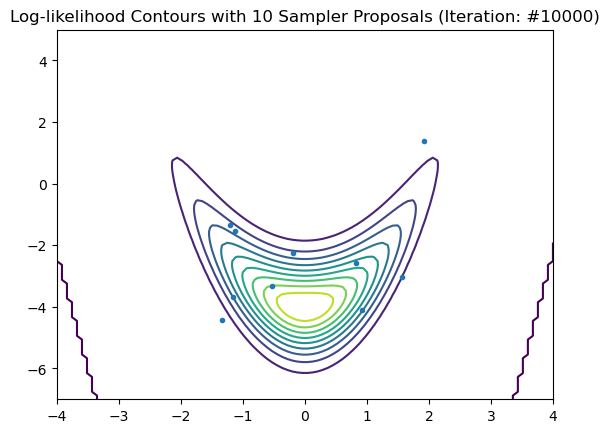

In [94]:
xp_np3 = x_list3[-1].detach().cpu().numpy()
plt.contour(X,Y,Z, levels=10)
plt.plot(xp_np3[:,0],xp_np3[:,1],'.')

plt.title('Log-likelihood Contours with 10 Sampler Proposals (Iteration: #10000)')
plt.show()

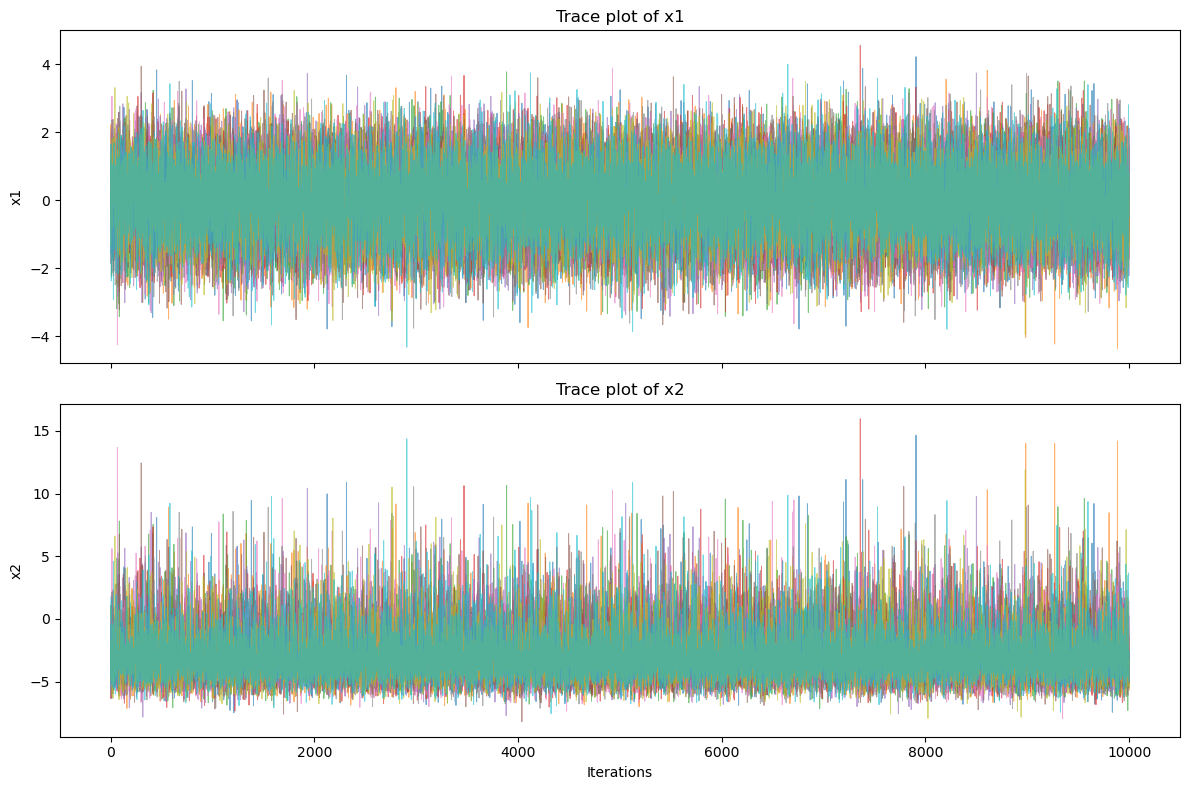

In [95]:
xp_np3 = np.array(x_list3)
iterations = xp_np3.shape[0]

param_names = ['x1','x2']

fig, axes = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)

# Loop over each parameter (e.g., Phase and Frequency)
for param_idx in range(2):
    ax = axes[param_idx]
    for chain_idx in range(xp_np3.shape[1]):
        ax.plot(
            np.arange(iterations),
            xp_np3[:,chain_idx, param_idx],
            alpha=0.6,
            linewidth=0.7
        )
    ax.set_ylabel(f'{param_names[param_idx]}')
    ax.set_title(f'Trace plot of {param_names[param_idx]}')

axes[-1].set_xlabel('Iterations')

plt.tight_layout()
plt.show()

In [96]:
# Define bin edges for histogramming
hist_0, _, _ = np.histogram2d(theory[:, 0], theory[:, 1], bins=[x_edges, y_edges], density=True)

kl_divergence3 = []
ess3 = []
for i in range(len(colors)):
    # Compute histogram of post-burnin samples for KL divergence
    chain_array = np.array(x_list3)  # shape: (chainlen-burnin+1, 2)
    hist_A, _, _ = np.histogram2d(chain_array[:,i,0], chain_array[:,i,1],
                                  bins=[x_edges, y_edges], density=True)
    prob_A = hist_A / np.sum(hist_A)
    prob_0 = hist_0 / np.sum(hist_0)
    prob_A_flat = prob_A.flatten() + 1e-10
    prob_0_flat = prob_0.flatten() + 1e-10
    kl_div = entropy(prob_0_flat, prob_A_flat)
    kl_divergence3.append(kl_div)

    ess1 = np.array([neff(chain_array[:,i,k]) for k in range(2)])
    ess3.append(ess1)

In [97]:
kl_divergence3, ess3

([1.0838330682247932,
  1.1090686919663997,
  1.0744093574827633,
  1.0492902888537883,
  1.0408316723302518,
  1.1412019045323325,
  1.132005349529872,
  1.096810971163577,
  1.1822542758361037,
  1.0892069585618844],
 [array([62350.42306545, 31727.51136143]),
  array([77256.18305615, 37781.61166308]),
  array([25974.19967341, 29262.38128812]),
  array([14027.86486714, 13528.3101535 ]),
  array([120544.64362816,  59353.1407058 ]),
  array([109543.4552283 ,  18558.76478952]),
  array([ 28491.5179119 , 144967.61868052]),
  array([18957.64706093, 70277.10689952]),
  array([48909.64066244, 29193.32264572]),
  array([ 46040.95418132, 100826.1891448 ])])

In [98]:
np.nanmean(kl_divergence3), np.nanmean(ess3,axis=0), np.mean(np.array(accept_vect.float()))

(1.0998912538481764, array([55209.65293352, 53547.5957332 ]), 1.0)